**Задание**: Попробуйте обучить методом Transfer Learning одну из готовых архитектур ResNet, VGG, etc. используя датасет кошки против собак.

Загрузка всех необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import requests, zipfile, io
import os
import cv2
from random import shuffle
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

## **Подготовка данных**

Загружаем данные из ссылки, которая была дана в чате (с гита).

In [ ]:
r = requests.get('https://github.com/laxmimerit/dog-cat-full-dataset/archive/refs/heads/master.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

Разделяю данные на обучающие и проверочные с помощью путей. Файлы загружены в сессионное хранилище колаба.

In [ ]:
train_dir = os.path.join('/content/dog-cat-full-dataset-master/data', 'train')
test_dir = os.path.join('/content/dog-cat-full-dataset-master/data', 'test')

Запоминаю пути к данным с помощью команды `join`, чтобы потом при загрузке изображений в массив их использовать и объединить.

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

Проверяем количество данных. Всего было 20000 изображений для обучения и 5000 изображений для теста.

In [ ]:
print('Количество изображений для обучения с кошками:  ', len(os.listdir(train_cats_dir)))
print('Количество изображений для обучения с собаками: ', len(os.listdir(train_dogs_dir)))
print('Всего: ', (len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir))))

print('Количество изображений для проверки с кошками:  ', len(os.listdir(test_cats_dir)))
print('Количество изображений для проверки с собаками: ', len(os.listdir(test_dogs_dir)))
print('Всего: ', (len(os.listdir(test_cats_dir)) + len(os.listdir(test_dogs_dir))))

Количество изображений для обучения с кошками:   10000
Количество изображений для обучения с собаками:  10000
Всего:  20000
Количество изображений для проверки с кошками:   2500
Количество изображений для проверки с собаками:  2500
Всего:  5000


Далее прописываю два необходимых метода: для массива правильных ответов с помощью метода `one-hot-encoder` и для самого массива изображений (чтоба привести их в цифровой формат). Изображения подписаны в виде `'cat.number.format'`

In [ ]:
def label_pet_image_one_hot_encoder(img):
    #Беру только первые три символа из названия
    pet = img.split('.')[-3]
    #в зависимости от категории создается массив
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

Структура каталога:

```
|dog-cat-full-dataset-master
 |data
    |test
       |cats
       |dogs
    |train
       |cats
       |dogs
```

  


In [ ]:
def process_data(data_image_list, isTrain=True):
    data_df = []#объявление массива для хранения данных изображения
    #прохожу по всем папкам до необходимой директории и файлов в ней
    for dir in os.listdir(data_image_list):
      for img in os.listdir(data_image_list +'/'+ dir):
        path = os.path.join(data_image_list +'/'+ dir, img)
        #в зависимости от того, тренировочный или тестовый набор данных, заполняю
        #массив переменной y
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        data_df.append([np.array(img),np.array(label)])
    #готовый массив перемешиваю, чтобы изображения были в разброс, а не по порядку
    shuffle(data_df)
    return data_df

In [ ]:
data_train = process_data(train_dir) #тренировочный массив

Далее для нагладности стоит вывести изображения, поэтому создаю для этого метод `show_image`

In [ ]:
def show_image(data_train):
  fig, axes = plt.subplots(nrows=1, ncols=len(data_train), figsize=(20, 20))
  for i, img in enumerate(data_train):
    #т.к. это массив, содержащийй и результат и сам массив цифр, то необходимо его разбить
    #перемемнная для Y
    img_label = img[1]
    #переменная для массива X
    img_data = img[0]
    label = np.argmax(img_label)
    axes[i].imshow(img_data)
    axes[i].axis('off')
    axes[i].set_title('cat' if label==0 else 'dog')
  plt.show()

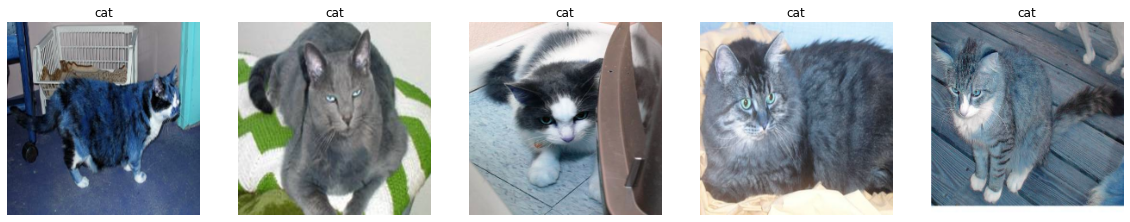

In [ ]:
show_image(data_train[:5]) #вывод первых 5ти изображений батча

In [ ]:
data_test = process_data(test_dir)#тестовый набор данных

In [ ]:
X_train = np.array([i[0] for i in data_train]).reshape(-1,224,224,3)
y_train = np.array([i[1] for i in data_train])

## **Сборка и обучение модели**

In [ ]:
model = Sequential()#объявление модели

Использую предобученную модель `ResNet50` и её веса `imagenet`. После чего добавляю ещё один слой с двумя выходами и функцией активации `softmax`

In [ ]:
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(2, activation='softmax'))
#первый слой ResNet-а уже обучен, поэтому его обучать не нужно
model.layers[0].trainable = True

Сборка модели. Оптимизатор `agd`, функция потерь - `crossentropy` и метрика `accuracy` для проверки

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

Разбиваю данные для тренировки и теста, который будет после обучения, пополам (50%). Этого достаточно для того, чтобы показатели модели были более `0.97`

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=2018)

Обучение модели. Размер батча составляет 64 изображения, всего будет 20 эпох и будет произведена валидация для лучшего обучения

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=20,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/20
157/157 [==============================] - 179s 1s/step - loss: 3.0926 - accuracy: 0.8962 - val_loss: 0.1363 - val_accuracy: 0.9551
Epoch 2/20
157/157 [==============================] - 122s 780ms/step - loss: 0.0577 - accuracy: 0.9809 - val_loss: 0.1057 - val_accuracy: 0.9658
Epoch 3/20
157/157 [==============================] - 122s 778ms/step - loss: 0.0191 - accuracy: 0.9956 - val_loss: 0.0835 - val_accuracy: 0.9674
Epoch 4/20
157/157 [==============================] - 122s 779ms/step - loss: 0.0076 - accuracy: 0.9995 - val_loss: 0.0872 - val_accuracy: 0.9696
Epoch 5/20
157/157 [==============================] - 135s 863ms/step - loss: 0.0051 - accuracy: 0.9994 - val_loss: 0.0856 - val_accuracy: 0.9734
Epoch 6/20
157/157 [==============================] - 122s 780ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.0844 - val_accuracy: 0.9734
Epoch 7/20
157/157 [==============================] - 122s 778ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0821 - va

Обучение заняло больше 40 минут. При этом произошло почти полное заполнение оперативной памяти, поэтому пришлось очистить некоторые переменные, чтобы продолжить дальнейшую проверку модели и не перезапускать сеанс. Переполнение оперативной памяти скорее всего вызвал неоптимизированный код

In [ ]:
X_train = []
y_train = []
data_train = 0

Выведу итоговые значения `loss` и `accuracy`. Есть гипотеза, что результат мог бы быть лучше, используй я больше данных для обучения, например 80%. Однако тогда я сталкиваюсь с проблемой перезаполнения ОЗУ и моё обучение невозможно даже начать.

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Функция ошибки:', score[0])
print('Accuracy:', score[1])

Функция ошибки: 0.08917998522520065
Accuracy: 0.9760000109672546


## **Результаты обучения модели**

Далее прописываю метод для прогнозирования данных из тестовой выборки и одновременная визуализация изображений. В целом, метод почти не отличается от метода `show_image`

In [ ]:
def show_results(data_test):
  fig, axes = plt.subplots(nrows=1, ncols=len(data_test), figsize=(20, 20))
  for i, img in enumerate(data_test):
    img_label = img[1]
    img_data = img[0]
    label = np.argmax(img_label)
    img_data = img_data.reshape(-1,224,224,3)
    #предсказание модели для конкретного изображения
    model_out = model.predict(img_data)
    if np.argmax(model_out) == 1 and label == 1:
      label='Its dog'
    elif np.argmax(model_out) == 0 and label == 0:
      label='Its cat'
    else:
      label='Не определен'
    axes[i].imshow(img[0])
    axes[i].axis('off')
    axes[i].set_title(label)
  plt.show()

Первый раз было выведено 10 изображений из тестового набора данных. При рассмотрении, можно увидеть, что 7 изображение было не определено моделью

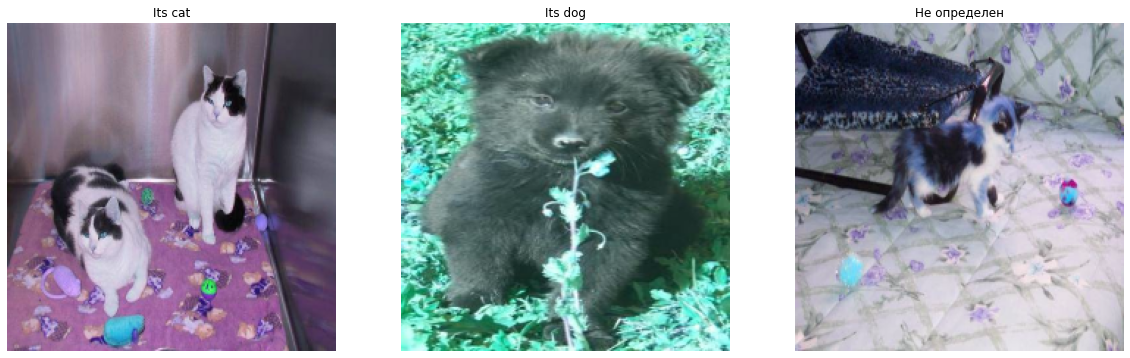

In [ ]:
show_results(data_test[3:6])

Хотелось бы протестировать модель на фотографиях кота, которые имеются у автора 😄

Метод для загрузки подготовленных изображений из сессионного хранилища

In [ ]:
def load_files(data_image_list):
    data_df = []
    #проходит по всем файлам в директории
    for img in os.listdir(data_image_list):
      #записывает путь к каждой конкретной фотографии
      path = os.path.join(data_image_list, img)
      img = cv2.imread(path,cv2.IMREAD_COLOR)
      #изменение размера
      img = cv2.resize(img, (224,224))
      #массив подготовленных изображений
      data_df.append([np.array(img)])
    return data_df

In [ ]:
arr_cats = load_files('/content/testdata/')

In [ ]:
X_test = np.array(arr_cats)

Переписанный метод `show_results` конкретно под подготовленные данные

In [ ]:
def show_results(data_test):
  fig, axes = plt.subplots(nrows=1, ncols=len(data_test), figsize=(15, 20))
  for i, img in enumerate(data_test):
    model_out = model.predict(img)
    if np.argmax(model_out) == 1:
      label='Это собака'
    else:
      label='Это кот'
    axes[i].imshow(img[0])
    axes[i].axis('off')
    axes[i].set_title(label)
  plt.show()

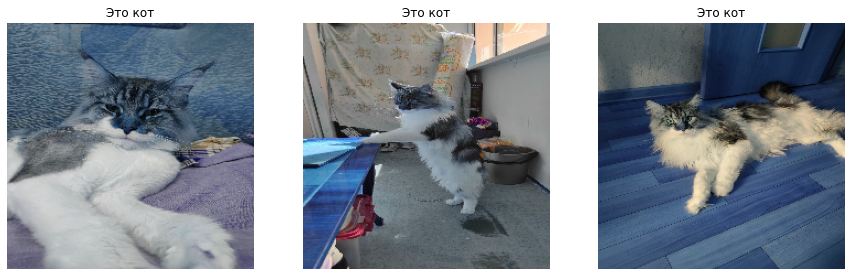

In [ ]:
show_results(X_test)

## **Вывод**

Исходя из поставленной задачи, был реализован подход transfer learning, который подразумевает использование заранее предобученных моделей, чтобы снизить время обучения написанных вручную моделей, использовать сильные наработки готовых моделей для увеличесния качества дописанной части. В целом, результат обученной модели на данных изображений кошек и собак составил 0.97 (`accuracy`).